# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you"ll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [1]:
# Clone repo
#!git clone https://$token@github.com/gerkone/jku.wad.git
#%cd jku.wad

In [2]:
# Install the dependencies
#!pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [3]:
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

In [4]:
from datetime import datetime
from collections import deque
from copy import deepcopy
import random
from torch import nn
from doom_arena import VizdoomMPEnv
import numpy as np
import torch 
import os
from datetime import datetime
from doom_arena.reward import VizDoomReward
from collections import defaultdict
from functools import singledispatchmethod
from tqdm.notebook import trange
import torch.nn as nn
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from typing import Dict, List
import torch
from collections import OrderedDict
import numpy as np
from datetime import datetime
from doom_arena.render import render_episode
from IPython.display import HTML
import os
import pandas as pd
import contextlib
#from agents.dqn import epsilon_greedy
#from agents.helpers import EnvActions

In [5]:
#from agents.utils import *
#from agents.visualizations import *
#from agents.helpers import *
#from agents.dqn import EfficientDQN, epsilon_greedy, soft_update_target_network, LargeDQN, SmallDQN

In [6]:
rng = np.random.default_rng(100)

In [7]:
class TqdmProgress:
    """A tqdm progress bar wrapper for training loops."""

    def __init__(self, total: int, desc: str = "Training", unit: str = "episode"):
        """
        Initializes the progress bar.

        Args:
            total (int): The total number of iterations (e.g., episodes).
            desc (str): A description for the progress bar.
            unit (str): The unit for one iteration.
        """
        self._iterable_pbar = trange(total, total=total, desc=desc, unit=f" {unit}")
        self.pbar = self._iterable_pbar
        self._total_steps = 0

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()

    def __iter__(self):
        yield from self._iterable_pbar

    def update_step_count(self, steps: int = 1):
        """
        Increments the total step counter.

        Args:
            steps (int): The number of steps to add.
        """
        self._total_steps += steps

    def set_description(self, current_episode: int):
        """
        Updates the description of the progress bar.

        Args:
            current_episode (int): The current episode number (0-indexed).
        """
        desc = f"Episode {current_episode + 1}/{self.pbar.total} | Total Training Steps: {self._total_steps:,}"
        self.pbar.set_description(desc)

    def set_postfix(self, stats: dict):
        """
        Updates the postfix of the progress bar with training statistics.
        """
        self.pbar.set_postfix(stats)

    def close(self):
        """Closes the progress bar."""
        self.pbar.close()



class YourReward(VizDoomReward):
    def __init__(self, num_players: int):
        super().__init__(num_players)
        self.prev_ammo = {}
        self.prev_health = {}
        self.prev_position = {}
        self.survival_bonus = 0
        
    def __call__(self, vizdoom_reward: float, game_var: dict[str, float], game_var_old: dict[str, float], player_id: int) -> tuple:
        """
        Custom reward functions
        * +100 for frags (kills)
        * +10 for hits
        * -2 for damage taken
        * +3 for movement (exploration)
        * +1 for ammo efficiency, +2 if ammo pickup
        * +0.05 survival bonus per step, -20 if dead
        * +2 if health pickup
        """
        
        """
            {'HEALTH': 100.0,  Can be higher then 100!
            'AMMO3': 0.0,
            'FRAGCOUNT': 0.0, # Number of players/bots killed, minus the number of committed suicides. Useful only in multiplayer mode
            'ARMOR': 0.0,
            'HITCOUNT': 0.0, # Counts number of hit monsters/players/bots during the current episode.
            'HITS_TAKEN': 0.0, # Counts number of hits taken by the player during the current episode.
            'DEAD': 0.0,
            'DEATHCOUNT': 0.0, # Counts the number of players deaths during the current episode. Useful only in multiplayer mode.
            'DAMAGECOUNT': 0.0, # Counts number of damage dealt to monsters/players/bots during the current episode. 
            'DAMAGE_TAKEN': 0.0,
            'KILLCOUNT': 0.0,
            'SELECTED_WEAPON': 2.0,
            'SELECTED_WEAPON_AMMO': 94.0, # Ammo for selected weapon.
            'POSITION_X': 389.96946716308594,
            'POSITION_Y': 274.2670135498047}
        """
        self._step += 1
        _ = vizdoom_reward, player_id  # unused
        
        def calc_movement(pos_x, pos_y, pos_x_old, pos_y_old):
            return np.sqrt((pos_x - pos_x_old)**2 + (pos_y - pos_y_old)**2).item() # Euclidean distance

        # Combat reward from hits
        rwd_frag = 100.0 * (game_var["FRAGCOUNT"] - game_var_old["FRAGCOUNT"])
        rwd_hit = 5.0 * (game_var["DAMAGECOUNT"] - game_var_old["DAMAGECOUNT"])
        rwd_hit_taken = -1 * (game_var["HITS_TAKEN"] - game_var_old["HITS_TAKEN"])
        
        # Movement reward
        pos_x, pos_y = game_var.get("POSITION_X", 0), game_var.get("POSITION_Y", 0)
        pos_x_old, pos_y_old = game_var_old.get("POSITION_X", 0), game_var_old.get("POSITION_Y", 0)
                
        movement_dist = calc_movement(pos_x, pos_y, pos_x_old, pos_y_old)
        rwd_movement = 0 #0.05 * min(movement_dist / 100.0, 1.0) # Max movement factor is 1
    
        # Ammo efficiency
        ammo_used = game_var_old.get("SELECTED_WEAPON_AMMO", 0) - game_var.get("SELECTED_WEAPON_AMMO", 0)
        hits_made = game_var["HITCOUNT"] - game_var_old["HITCOUNT"]
        
        if ammo_used > 0: # Shots fired
            accuracy = min(hits_made / ammo_used, 1.0)  # Cap at 100%
            rwd_ammo_efficiency = 2.0 * accuracy
    
        elif ammo_used < 0: # Picked up ammunition
            rwd_ammo_efficiency = 2.0
            
        else:
            rwd_ammo_efficiency = 0.0
            
        # Survival bonus
        health_ratio = game_var["HEALTH"] / 100.0
        is_alive = game_var["HEALTH"] > 0
        rwd_survival = (-0.01 + 0.005 * health_ratio) if is_alive else -20.0 # THe higher the health percentage the higher the reward, not linearly

        # Bonus point if a reward is picked up
        rwd_health_pickup = +5.0 if game_var["HEALTH"] > game_var_old["HEALTH"] else 0.0
        
        return rwd_frag, rwd_hit, rwd_hit_taken, rwd_movement, rwd_ammo_efficiency, rwd_survival, rwd_health_pickup

class ExtraStates():
    """ Class to store the state informations and calculations. """
    # States in correct order
    EXTRA_STATE_INFOS = {
        "screen": {"dim": 3, "index": 0},
        "labels": {"dim": 1, "index": 3},
        "depth": {"dim": 1, "index": 4},
        "automap": {"dim": 3, "index": 5}
        }
    
    def __init__(self, selected_states: list, num_frames: int = 1):
        self.states = [key for key in self.EXTRA_STATE_INFOS.keys() if key in selected_states]
        self.states_infos = {key: values for key, values in self.EXTRA_STATE_INFOS.items() if key in self.states}
        self.num_states = len(self.states)
        self.num_frames = num_frames
        
    def __len__(self):
        return len(self.states)
    
    def get_state_info(self, info: str, return_dict: bool = True) -> dict|list:
        if isinstance(info, str):
            filtered_infos_dict = {key: infos.get(info, None) for key, infos in self.states_infos.items()}
            
            if return_dict:
                return filtered_infos_dict
        
            else:
                return list(filtered_infos_dict.values())
    
    def get_dims(self, return_dict: bool = True) -> dict|list:
        return self.get_state_info("dim", return_dict)
    
    def get_indices(self, return_dict: bool = True) -> dict|list:
        return self.get_state_info("index", return_dict)
    
    def get_channels(self, num_frames: int = None):
        """ TODO: input_channels per state. Currently only for model initialization. """
        if num_frames is not None:
            self.num_frames = num_frames
            
        return {k: v * self.num_frames for k, v in self.get_dims().items()}

class EnvActions():
    action_weights = {
            'Noop': 0.05,
            'Move Forward': 0.2,
            'Attack': 0.25,
            'Move Left': 0.10,
            'Move Right': 0.10,
            'Turn Left': 0.12,
            'Turn Right': 0.12,
            'Jump': 0.05}
    
    def __init__(self, env, seed: int = 149, rng = None) -> None:
        self.set_actions_from_env(env)
        self.action_space = len(self)
        
        if rng is not None:
            self.rng = rng
        elif seed is not None:
            self.rng = np.random.default_rng(seed)
        
    def __len__(self) -> int:
        return len(self.actions)
    
    def set_actions_from_env(self, env) -> None:
        self.actions = {0: "Noop"}

        for player_env in env.envs:
            for idx, action in enumerate(player_env.game.get_available_buttons()):
                action_name = str(action).split(".")[1].split(":")[0].replace("_", " ")
                action_val = idx + 1
                
                self.actions[action_val] = action_name.title()
    
    def get_actions(self, return_vals_list: bool = False) -> dict|list:
        if return_vals_list:
            return list(self.actions.values())
        
        return self.actions
    
    def get_action_name(self, action_num: int) -> str:
        return self.actions.get(action_num, "Unknown Action")
    
    @singledispatchmethod
    def get_action_value(self, arg1, arg2):
        """Gets the action value(s) for the given index or list of indices."""
        raise NotImplementedError(f"Cannot get action value for types {type(arg1)} and {type(arg2)}")

    @get_action_value.register
    def _(self, index: int, num=1) -> int|list:    
        all_buttons = list(self.actions.keys())
    
        if num == 1:
            return all_buttons[index]
        
        return [all_buttons[index] for _ in range(num)]
    
    @get_action_value.register
    def _(self, indices: list, num=1) -> list:
        return [self.get_action_value(index) for index in indices]
    
    def get_action_proba(self) -> np.ndarray:
        # Calculate the probability of each action
        action_weight_vals = np.array(list(self.action_weights.values()))
        action_proba = action_weight_vals / action_weight_vals.sum()
        
        return action_proba
        
    def get_random_action(self, n: int = 1, use_proba: bool = True) -> int | list:
        if n <= 0:
            return []

        if use_proba:
            action_proba = self.get_action_proba()
            selection = self.rng.choice(list(self.actions.keys()), p=action_proba, size=n)
        else:
            selection = self.rng.choice(list(self.actions.keys()), size=n)

        if n == 1:
            return selection.item()
        
        return selection.tolist()
    
class ActionCounter:
    """ Class to count the occurrences of each action. """
    def __init__(self):
        self.counts = defaultdict(int)

    def add(self, action: int):
        """ Increments the count for a given action. """
        self.counts[action] += 1

    def get_counts(self) -> dict[int, int]:
        """ Returns the current action counts. """
        return dict(self.counts) # Return a regular dict

    def reset(self):
        """ Resets all action counts. """
        self.counts.clear()
        
    def get_name_counts(self, env_actions: EnvActions) -> dict[str, int]:
        """ Returns the current action counts and names. """
        return {env_actions.get_action_name(key): self.counts.get(key, 0) for key in sorted(self.counts.keys())}
        

class LossLogger():
    """ Class to log the losses during training or evaluation. """
    def __init__(self):
        self.all_losses = list()
        self.loss: float = 0.0
        self.num_batches: int = 0
        
    def add(self, loss: torch.Tensor):
        """ Adds the loss tensor. """
        self.loss += loss.detach().item()
        self.num_batches += 1

    def get_loss(self)-> float:
        """ Returns the average loss as float. """
        if self.num_batches > 0:
            return self.loss / self.num_batches
        else:
            return 0.0
        
    def reset_on_epoch(self):
        """ Resets the losses after an epoch. """
        if self.num_batches > 0:
            self.all_losses.append(self.get_loss())
            self.loss = 0.0
            self.num_batches = 0


class Logger():
    def __init__(self, path: str, filename: str = "logs.txt", also_print: bool = False):
        """ Initialize a logger class that logs the messages to a file but is also capable of printing it.

        Args:
            path (str): Path to store the log file
            also_print (bool, optional): Whether every log should also be printed (Tipp: self.log() allows for one-time printing, too!). Defaults to False.
        """
       
        self.path = path
        self.filename = filename
        self.also_print = also_print
        self.file_path = os.path.join(self.path, self.filename)
        
        self.create_log_file()
    
    def log(self, msg: str, print_once: bool = False, improve_file_output: bool = False, end="\n"):
        
        if self.also_print or print_once:
            print(msg)
            
        with open(self.file_path, "a") as f:
            if improve_file_output:
                msg = msg.replace("|", ",")
                msg = msg.replace("\t", "")
                msg = msg.replace("  ", "")
                msg = msg.strip()
            
            f.write(msg + end)

    def create_log_file(self):
        # Ensure the directory exists
        if not os.path.exists(self.path):
            os.makedirs(self.path, exist_ok=True)
            
        with open(self.file_path, "w") as f:
            f.write(F"LOGGER INITIALIZED AT {datetime.now().strftime('%Y%m%d-%H%M%S')}\n")
             
            
class ActivationLogger(Logger):
    def __init__(self, path: str, filename: str = "activations.txt", also_print: bool = False):
        super().__init__(path, filename, also_print)
        
    def analyze_activations(self, activations: torch.Tensor, episode: int = -1, title: str = "", print_once: bool = False) -> str:
        return f"Episode {episode} | {title:<15}| Shape: {list(activations.shape)},\tMean: {activations.mean().item():.2f},\tStd: {activations.std().item():.2f},\tNorm: {torch.norm(activations).item():.2f}"
            
    @torch.no_grad()
    def log_model_activations(self, obs:tuple[torch.Tensor], model: torch.nn.Module, model_sequence: list = [None, 0, 1, 1], episode: int = -1, print_once: bool = False, return_activations_from_idx:  int = -1):       
        
        orig_device = next(model.parameters()).device
        model.eval().cpu()
        if isinstance(obs, tuple):
            obs = tuple([o.cpu() for o in obs])
        
        elif isinstance(obs, list):
            obs = [o.cpu() for o in obs]
            
        elif isinstance(obs, torch.Tensor):
            obs = obs.cpu()
            
        # Get all modules ot the model except for activation functions        
        all_modules = [name for name, _ in model.named_children() if name != "phi"]
        
        # Create a dictionary with relevant information that stores all data
        module_info = {idx: {"name": module, 
                             "sequence": sequence, 
                             "logits": None} 
                       for idx, (module, sequence) in enumerate(zip(all_modules, model_sequence))}
        
        # Store all texts at one place
        log_str = ""
        
        # Iterate over provided sequences and log 
        for module_idx, module_vals in module_info.items():
            name = module_vals.get("name", "Unknown Module") # Get the name
            sequence = module_vals.get("sequence") # Get the sequence, that is order where to retrieve from
            module: torch.nn.Module = getattr(model, name) # Get the module as instance

            if sequence is None:
                module_input = obs
            else:
                module_input = module_info.get(sequence).get("logits") # If module needs logits form previously get them
            
            module_logits = module.forward(module_input) # Make forward pass
            module_info[module_idx]["logits"] = module_logits # Append forward pass to module info dictionary
            
            log_str += self.analyze_activations(module_logits, episode, name, print_once) + "\n" # Analyze the logits
            
        # Log all values together
        self.log(log_str, print_once, improve_file_output=True)

        # Put model on original device
        model.to(orig_device)
        
        # Return the last X activations if necessary
        if return_activations_from_idx is not None:
            return_idx = len(all_modules) + return_activations_from_idx if return_activations_from_idx < 0 else return_activations_from_idx
            
            all_indices = list(module_info.keys())
            selected_indices = all_indices[return_idx:]
            
            return [value.get("logits") for key, value in module_info.items() if key in selected_indices]
        
    def analyze_weights(self, weights: torch.Tensor, episode: int = -1, title: str = "", layer_type: str = "unknown", print_once: bool = False) -> str:
        """
        Analyze weight statistics for a given layer
        
        Args:
            weights: Weight tensor to analyze
            episode: Episode number
            title: Layer name/title
            layer_type: Type of layer (conv, linear, etc.)
            print_once: Whether to print once or always
        
        Returns:
            Formatted string with weight statistics
        """
        # Basic statistics
        mean_val = weights.mean().item()
        std_val = weights.std().item()
        norm_val = torch.norm(weights).item()
        
        # Advanced statistics for training monitoring
        min_val = weights.min().item()
        max_val = weights.max().item()
        abs_mean = weights.abs().mean().item()
        
        # Gradient flow indicators
        near_zero_ratio = (weights.abs() < 1e-6).float().mean().item()
        large_weight_ratio = (weights.abs() > 1.0).float().mean().item()
        
        # Weight distribution analysis
        q25 = torch.quantile(weights.flatten(), 0.25).item()
        q75 = torch.quantile(weights.flatten(), 0.75).item()
        
        # Sparsity measure (useful for detecting dead neurons)
        sparsity = (weights == 0).float().mean().item()
        
        return f"Episode {episode} | {title:<15}| Type: {layer_type:<6}| Shape: {list(weights.shape)}, Mean: {mean_val:.4f}, Std: {std_val:.4f}, Norm: {norm_val:.2f}, Range: [{min_val:.4f}, {max_val:.4f}], AbsMean: {abs_mean:.4f}, NearZero%: {near_zero_ratio:.2%}, Large%: {large_weight_ratio:.2%}, Q25/75: [{q25:.4f}, {q75:.4f}], Sparsity: {sparsity:.2%}"

        
    @torch.no_grad()
    def log_model_weights(self, model: torch.nn.Module, episode: int = -1, print_once: bool = False, include_bias: bool = True):
        """
        Log weight statistics for all layers in the model
        
        Args:
            model: PyTorch model to analyze
            episode: Episode number
            print_once: Whether to print once or always
            include_bias: Whether to include bias terms in analysis
        """
        orig_device = next(model.parameters()).device
        model.cpu()
        
         # Get all modules ot the model except for activation functions        
        all_modules = [name for name, _ in model.named_children() if name != "phi"]
        
        log_str = ""
        
        for module_name in all_modules:
            model_module: torch.nn.Module = getattr(model, module_name)
            for enc_idx, encoder in enumerate(model_module.modules_list):
                for name, sub_module in encoder.named_modules():
                    if len(list(sub_module.parameters())) > 0:  # Only modules with parameters
                        for param_name, param in sub_module.named_parameters():
                            if 'weight' in param_name or (include_bias and 'bias' in param_name):
                                layer_type = type(sub_module).__name__.lower()
                                full_name = f"enc{enc_idx}_{name}_{param_name}" if name else f"enc{enc_idx}_{param_name}"
                                log_str += self.analyze_weights(param.data, episode, full_name, layer_type, print_once) + "\n"
        
        
        all_weights = torch.cat([p.data.flatten() for p in model.parameters() if p.requires_grad])
        log_str += self.analyze_weights(all_weights, episode, "ALL_WEIGHTS", "global", print_once) + "\n"
        
        log_str += f"{'='*120}\n"
        
        # Log everything
        self.log(log_str, print_once, improve_file_output=True)
        
        # Restore original device
        model.to(orig_device)

                
        

In [8]:
      
class Parallel(nn.Module):
    def __init__(self, modules: list[nn.Module]):
        super().__init__()
        if not isinstance(modules, list):
            raise ValueError("Modules are not lists!")
        
        self.model = nn.ModuleList(modules)
        #self.model = nn.ModuleDict(modules) # Otherwise modules are not registered correctly

    def forward(self, inputs: tuple) -> torch.Tensor:
        all_logits = []
        
        for module, input in zip(self.model, inputs):
            all_logits.append(module(input))
            
        return torch.cat(all_logits, dim=1)
    
class OwnModule(nn.Module):
    def __init__(self):
        super().__init__()
        
    def init_weights(self, debug: bool=False):  
        """ Initialize weights for Linear features. Kaiming He for (Leaky-)Relu otherwise Xavier """
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if isinstance(self.phi, nn.ReLU):
                    nn.init.kaiming_uniform_(module.weight, nonlinearity="relu")
                    print("Weights initialized with Kaiming He") if debug else None
                elif isinstance(self.phi, nn.LeakyReLU):
                    nn.init.kaiming_uniform_(module.weight, nonlinearity="leaky_relu")
                    print("Weights initialized with Kaiming He") if debug else None
                else:
                    nn.init.xavier_uniform_(module.weight) 
                    print("Weights initialized with Glorot") if debug else None
                    
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                    
    def get_padding(self, kernel_size: int) -> int:
        """ Preserve the image size if stride is one, otherwise reduce spacial dimension """
        return (kernel_size - 1) // 2
        
    def get_size_estimate(self) -> float:
        param_size = 0
        buffer_size = 0
        for param in self.parameters():
            param_size += param.nelement() * param.element_size()

        for buffer in self.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()

        size_all_mb = (param_size + buffer_size) / 1024**2 # Conversion from bytes to megabytes
    
        return size_all_mb
    
    def save_model(self, path: str = "", filename: str = "model.pt"):
        """ Saves the model's state dict at the provided path in a subfolder based on the date. Name: "model.pt"

        Args:
            path (str, optional): Path where the model should be stored. Defaults to "".
        """
        
        try:
            dir_path = os.path.dirname(os.path.realpath(__file__)) if path == "" else path     
            os.makedirs(dir_path, exist_ok=True)
            
            file_path = os.path.join(dir_path, filename)
            
            checkpoint = dict(
                architecture= dict(
                    input_dim = self.input_dim,
                    action_space=self.action_space,
                    obs_state_infos=self.obs_state_infos,
                    feature_dim_cnns = self.feature_dim_cnns,
                    hidden_dim_heads = self.hidden_dim_heads,
                    phi = self.phi,
                ),
                state_dict = self.state_dict()
            )
            
            torch.save(checkpoint, file_path)
            
            print(f"Successfully stored the model: {file_path}")
        
        except Exception as e:
            print(f"Failed to store the model: {e}")
            
    
        
    
    @classmethod  
    def load_model(cls, path: str = ""):
        """ Loads an instance of this model class from the provided path. 

        Args:
            path (str, optional): Path to the state dicht. Defaults to "".

        Returns:
            PM_Model: An instance of the model class.
        """
        try:
            checkpoint = torch.load(path, weights_only=False)
                        
            arch_params = checkpoint.get("architecture")
            state_dict = checkpoint.get("state_dict")

            if arch_params is None or state_dict is None:
                print(f"Failed to load model: Checkpoint file {path} is missing 'architecture' or 'state_dict'.")
                return None

            loaded_model = cls(**arch_params)
            loaded_model.load_state_dict(state_dict)
            
            return loaded_model
        
        except Exception as e:
            print(f"Failed to load the model: {e}")

In [9]:
@torch.no_grad()
def process_observation(obs: torch.Tensor, state_dims: dict = {}, device: str = "cpu", dtype = torch.float32, permute: bool = False) -> torch.Tensor|Dict[str, torch.Tensor]:
    """Process multi-buffer observation from environment, for training and for plotting. Returns a dictionary with the state as key and data as value. """
    """ NOTE: state dims is only for splitting it -> depreceated as model now does the transformation itself!"""
    if isinstance(obs, torch.Tensor) and obs.size()[1] > 1:
                
        # Put state channel at the end for plotting (color detection)
        if permute and obs.ndim == 3:
            obs = obs.permute(1,2,0)
            
        elif permute and obs.ndim == 4:
            obs = obs.permute(0,2,3,1)
        
        obs = obs.to(device, dtype=dtype)
        
        if state_dims:
            state_dim_idx = obs.ndim - 1 if permute else obs.ndim - 3 # if permute last channel, regular case: channel 0 if 3 dimensions, otherwise channel 1 as 0 is batches.
            obs_states = obs.split(list(state_dims.values()), dim=state_dim_idx)
            return dict(zip(state_dims.keys(), obs_states))
        
        return obs
        
    else:
        # Fallback: Single observation case
        return {'screen': obs.to(device, dtype=dtype)}


@torch.no_grad()
def epsilon_greedy(env, model: nn.Module, obs: list, epsilon: float, env_actions: EnvActions, device: str = "cpu", dtype = torch.float32, action_counter: ActionCounter = None, debug: bool = False):
    """Epsilon-greedy action selection for multi-buffer observations"""

    num_players = env.num_players
    
    if random.random() < epsilon:
       
        # One different action (1-7) per player
        chosen_actions = env_actions.get_random_action(n=num_players, use_proba=True)
        print("WITHIN EPSILON:", chosen_actions) if debug else None
        
    else:
        model.eval()
        
        if not isinstance(obs, torch.Tensor):
            obs = torch.stack(obs) # stack players
        
        processed_obs = process_observation(obs, device=device, dtype=dtype, permute=False)
        q_values = model(processed_obs)
        
        # Indices are necessary if buttons don't start at 0 but at 1 (e.g., if there wouldn't be a noop option)
    
        if num_players == 1:
            chosen_actions_idx = q_values.argmax().to(dtype=int).item() # Single action
            print("DEBUG EPSILON NUM PLAYERS=1:", chosen_actions_idx, q_values, end="")  if debug else None
        else:
            chosen_actions_idx = q_values.argmax(dim=1).to(dtype=int).tolist() # list of actions
            print("DEBUG EPSILON NUM PLAYERS>1:", chosen_actions_idx, q_values, end="")  if debug else None
        
        chosen_actions = env_actions.get_action_value(chosen_actions_idx) 
        print(chosen_actions) if debug else None
        
    # Add to action counter
    if action_counter:
        if isinstance(chosen_actions, list):
            for action in chosen_actions:
                action_counter.add(action)
        else: # single action
            action_counter.add(chosen_actions)

    return chosen_actions

def hard_update_target_network(target_net: nn.Module, main_net: nn.Module):
    """Hard update of target network"""
    target_net.load_state_dict(main_net.state_dict())
    
    
    # Update Target network
def soft_update_target_network(local_model: nn.Module, target_model: nn.Module, tau: float):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    # TODO: Update target network
    
    # Store current state dicts
    local_state_dict = local_model.state_dict()
    target_state_dict = target_model.state_dict()
    
    # Iterate over the modules and soft update the target state dict with parameter tau
    for module in local_state_dict.keys():
        target_state_dict[module] = local_state_dict[module] * tau + target_state_dict[module] * (1 - tau)
    
    # Load the soft updated values
    target_model.load_state_dict(target_state_dict)


class EfficientDQN(OwnModule):
    """
    EfficientDQN with multi-buffer visual processing
    """
    
    def __init__(self, input_dim: int, action_space: int, obs_state_infos: ExtraStates, feature_dim_cnns: int = 256, hidden_dim_heads: int = 1024, phi: nn.Module = nn.LeakyReLU(), dropout_p:float = 0.15):
        #obs_state_infos: ExtraStates = None, 
        super().__init__()
        self.input_dim = input_dim # not used
        self.obs_state_infos = obs_state_infos
        self.action_space = action_space
        self.hidden_dim_heads = hidden_dim_heads
        self.phi = phi
        self.dropout_p = dropout_p
        
        # Feature dimension after encoding
        self.feature_dim_cnns = feature_dim_cnns

        # Observation states info
        self.obs_state_dims = obs_state_infos.get_dims(return_dict=False) # Indices to split the observation
        self.obs_states_num = obs_state_infos.num_states
        
        # Separate encoders for each buffer type
        self.encoders = Parallel([self._build_encoder(dim) for dim in self.obs_state_dims])
        
        
        self.head_first = nn.Sequential(
            #nn.Linear(self.feature_dim_cnns * self.obs_states_num, self.hidden_dim_heads),
            nn.Linear(np.array([2*2*4 * [32 if dim == 3 else 16 for dim in self.obs_state_dims]]).sum(), self.hidden_dim_heads),
            nn.Dropout(self.dropout_p),
            self.phi
        )
        
        # Dueling network heads
        self.value_head = nn.Sequential(
            nn.Linear(self.hidden_dim_heads, self.hidden_dim_heads // 8),
            nn.Dropout(self.dropout_p),
            self.phi,
            nn.Linear(self.hidden_dim_heads // 8, 1)
        )
        
        self.advantage_head = nn.Sequential(
            nn.Linear(self.hidden_dim_heads, self.hidden_dim_heads // 8),
            nn.Dropout(self.dropout_p),
            self.phi,
            nn.Linear(self.hidden_dim_heads // 8, action_space) 
        )
        
        params_encoder = sum(p.numel() for p in self.encoders.parameters() if p.requires_grad)
        params_head_first = sum(p.numel() for p in self.head_first.parameters() if p.requires_grad)
        params_advantage_head = sum(p.numel() for p in self.advantage_head.parameters() if p.requires_grad)
        params_value_head = sum(p.numel() for p in self.value_head.parameters() if p.requires_grad)
                
        
        print(f"Initialized model with {params_encoder  + params_head_first + params_advantage_head + params_value_head} parameters!")
    
    def _build_encoder(self, input_channels: int) -> nn.Module:
        """Build CNN encoder with residual blocks for visual input"""
        
        first_channel_out = 32 if input_channels == 3 else 16
        
        return nn.Sequential(
            # Initial convolution - reduce spatial dimensions significantly
            nn.Conv2d(input_channels, first_channel_out, 8, stride=4, padding=2),
            nn.GroupNorm(4, first_channel_out),
            self.phi,  # Output [N, C=16/4, WH=32

            # Second CNN stage - double channels
            nn.Conv2d(first_channel_out, first_channel_out * 2, 4, stride=3, padding=0), # [N, 2C, 10]
            nn.GroupNorm(8, first_channel_out * 2),
            self.phi,
            
            # Third residual stage - double channels again, with kernel
            nn.Conv2d(first_channel_out * 2, first_channel_out * 4, 4, stride=2, padding=0), # [N, 4C, 4]
            nn.GroupNorm(16, first_channel_out * 4),
            self.phi,
            
            # Fourth residual stage - double channels again, with kernel
            nn.Conv2d(first_channel_out * 4, first_channel_out * 4, 2, stride=2), # [N, 4C, 4]
            nn.GroupNorm(16, first_channel_out * 4),
            self.phi,
            
            nn.Flatten(),
        )

    
    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through multi-buffer DQN
        
        Args:
            observations: Tensor for "screen", "depth", "labels", "automap"
        """                
        # Encode each visual buffer and split the observations
        features = self.encoders(observations.split(self.obs_state_dims, dim=1))

        # Use one head for the dueling network                
        head_logits = self.head_first(features)

        # Dueling network computation
        value = self.value_head(head_logits)

        advantage = self.advantage_head(head_logits)

        # Combine value and advantage
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        return q_values
    

In [10]:

#from agents.dqn import process_observation

def plot_reward_components(reward_log, smooth_window: int = 5):
    """
    Plot raw and smoothed episode-level reward components.

    Parameters
    ----------
    reward_log : list[dict]
        Append a dict for each episode, e.g. {"frag": …, "hit": …, "hittaken": …}
    smooth_window : int
        Rolling-mean window size for the smoothed curve.
    """
    if not reward_log:
        print("reward_log is empty – nothing to plot.")
        return

    df = pd.DataFrame(reward_log)
    df_smooth = df.rolling(window=smooth_window, min_periods=1).mean()

    # raw
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title("Raw episode reward components")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # smoothed
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df_smooth[col], label=f"{col} (avg)")
    plt.title(f"Smoothed (window={smooth_window})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def plot_training_metrics(reward_history, loss_history, epsilon_history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Reward history
    axes[0, 0].plot(reward_history)
    axes[0, 0].plot(pd.Series(reward_history).rolling(50).mean(), "r-", alpha=0.7)
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].grid(True)
    
    # Loss history
    if loss_history:
        axes[0, 1].plot(loss_history)
        axes[0, 1].plot(pd.Series(loss_history).rolling(100).mean(), "r-", alpha=0.7)
        axes[0, 1].set_title("Training Loss")
        axes[0, 1].set_xlabel("Training Step")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].grid(True)
    
    # Epsilon decay
    axes[1, 0].plot(epsilon_history)
    axes[1, 0].set_title("Epsilon Decay")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Epsilon")
    axes[1, 0].grid(True)
    
    # Reward distribution
    axes[1, 1].hist(reward_history, bins=50, alpha=0.7)
    axes[1, 1].set_title("Reward Distribution")
    axes[1, 1].set_xlabel("Reward")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    
def plot_images(obs: torch.Tensor, state_dims: dict, **kwargs):
    """ Plots each state of the observations in one plot. """
    
    num_plots = len(state_dims)
    
    obs_processed = process_observation(obs, state_dims, device="cpu", permute=True)
    
    last_plot = 1
    
    if kwargs:
        plt.suptitle(kwargs.get("title", ""))
    
    def add_plot(data, last_plot, title):
        plt.subplot(100 + 10*num_plots + last_plot)
        plt.imshow(data)
        plt.axis("off")
        plt.title(title)
        return last_plot + 1

    for key in state_dims.keys():
        last_plot = add_plot(obs_processed.get(key), last_plot, key)
    
    plt.tight_layout()
    plt.show()

In [11]:

def replay_episode(env, model, device, dtype, path: str = "", store: bool = False, random_player: bool = True):
    # ----------------------------------------------------------------
    # Hint for replay visualisation:
    # ----------------------------------------------------------------

    env.enable_replay()

    # Tracking reward components
    eval_reward = 0.0

    # Reset environment
    with suppress_output():
        eval_obs = env.reset()
    
    eval_dones = [False]
    model.cpu()

    while not all(eval_dones):
        env_actions = EnvActions(env)
        
        eval_act = epsilon_greedy(env, model, eval_obs, 0, env_actions, "cpu", dtype=dtype)
        eval_obs, reward_components, eval_dones, _ = env.step(eval_act)
        eval_reward += sum(reward_components)

    print(f"Final evaluation - Total reward: {eval_reward:.1f}")

    # Finalize episode
    env.disable_replay()

    replays = env.get_player_replays()

    if random_player:
        # Random Player
        player_idx = np.random.randint(0, len(replays))
        player_name = list(replays.keys())[player_idx]
        replays = {player_name: replays.get(player_name)}
    
    if store:
        path = os.path.join(path, f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{eval_reward:.0f}.mp4")
        render_episode(replays, subsample=5, replay_path=path)
    else:
        HTML(render_episode(replays, subsample=5).to_html5_video())

    model.train()
    model.to(device)
    
    
def get_average_result(episode_metrics: Dict[int, dict]) -> dict:
    """ Returns the average reward from all players for each reward type. """
    averaged_metrics = dict()

    for values in episode_metrics.values():
        for key, reward_val in values.items():
            if isinstance(averaged_metrics.get(key), list):
                averaged_metrics[key].append(reward_val)
            else:
                averaged_metrics[key] = [reward_val]
                
    return {key: np.mean(value, dtype=int) for key, value in averaged_metrics.items()}
        

def get_avg_reward(reward_history: dict, episodes: int = 1, player_idx: int=-1, round:int = 2) -> np.ndarray:
    """ Returns the average reward for the episode or player id

    Args:
        reward_history (dict): A dictionary with player id as key and the rewards as values
        episodes (int, optional): Number of last episode to extract. Defaults to 1 (=last).
        player_idx (int, optional): Player idx to filter. Defaults to -1.

    Returns:
        np.ndarray: Average rewards as an array
    """
    df_rwds = pd.DataFrame.from_dict(reward_history)
    
    if player_idx == -1:
        df_rwds = df_rwds.mean(axis=1) # Mean over columns
        
    else:
        df_rwds = df_rwds.iloc[:, player_idx]
        
    if episodes > 1:
        df_rwds = df_rwds[-episodes:].mean(axis=0) # Mean over columns
    else:
        df_rwds = df_rwds.iloc[episodes]
        
    return np.round(df_rwds, round)
        

@contextlib.contextmanager
def suppress_output():
    """Suppress both stdout and stderr, including output from C extensions."""
    with open(os.devnull, 'w') as devnull:
        # Save original file descriptors
        old_stdout_fd = os.dup(1)
        old_stderr_fd = os.dup(2)

        try:
            # Redirect stdout and stderr to devnull
            os.dup2(devnull.fileno(), 1)
            os.dup2(devnull.fileno(), 2)

            # Also suppress Python-level stdout/stderr
            with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
                yield
        finally:
            # Restore original file descriptors
            os.dup2(old_stdout_fd, 1)
            os.dup2(old_stderr_fd, 2)
            os.close(old_stdout_fd)
            os.close(old_stderr_fd)
    

In [12]:
# Create folder for training
training_id = datetime.now().strftime("%Y%m%d_%H%M%S")
training_folder = os.path.join("runs", training_id)
#training_folder = os.path.join("runs", "Testing")

os.makedirs(training_folder, exist_ok=True)
print("Using folder:", training_folder)

# Define loggers
logger = Logger(training_folder, also_print=True)
activation_logger = ActivationLogger(training_folder, filename="activations.txt", also_print=False)

Using folder: runs/20250622_034926


## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [13]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1, #4, # 1 # Temporal information
    "extra_state": ["depth"],#, "labels"], #["labels"],#, "automap"], #["depth", "labels", "automap"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

In [ ]:
# TODO: environment training paramters
N_STACK_FRAMES = 1 # 4 does not work yet!
NUM_PLAYERS = 4 #3
NUM_BOTS = 6 #1, #6
EPISODE_TIMEOUT = 2000
# TODO: model hyperparams
GAMMA = 0.95
EPISODES = 1400 #2 # 500
BATCH_SIZE = 128
REPLAY_BUFFER_SIZE = 15_000
LEARNING_RATE = 1e-5
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.998 # 0.987
N_EPOCHS = 20
FRAME_SKIPPING = 0
FRAME_SKIPPING_STOP = 100
DEBUG = True
PRINT_EVERY = 50
VIDEO_DURING_TRAINING = True
EVALUATION_EVERY = 100

In [15]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

DTYPE = torch.float32

obs_states = ExtraStates(PLAYER_CONFIG["extra_state"] + ["screen"], num_frames = N_STACK_FRAMES)

reward_fn = YourReward(num_players=NUM_PLAYERS)

def build_env():
    env = VizdoomMPEnv(
        num_players=NUM_PLAYERS, # 4 is max
        num_bots=NUM_BOTS,
        bot_skill=1, # Increased difficulty
        doom_map="TRNM",  # ROOM = NOTE simple, small map; other options: TRNM, TRNMBIG
        extra_state=PLAYER_CONFIG["extra_state"],  # see info about states at the beginning of "Environment configuration" above
        episode_timeout=EPISODE_TIMEOUT,
        n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
        crosshair=PLAYER_CONFIG["crosshair"],
        hud=PLAYER_CONFIG["hud"],
        screen_format=PLAYER_CONFIG["screen_format"],
        reward_fn=reward_fn,
        seed = rng.integers(1, 2000, NUM_PLAYERS),
        ticrate = 35#*3,
    )
    return env

env = build_env()
with suppress_output(): # Reset to get player and game information
    _ = env.reset()

Device: mps
Environment Seed: [1534 1670  249]
Host 49359
Player 49359


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [16]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================
env_actions = EnvActions(env, rng=rng)

# main Q-network
model = EfficientDQN(
    input_dim = 0,
    action_space=env_actions.action_space,
    obs_state_infos=obs_states,
).to(device, dtype=DTYPE)

# Load a model from file
#model = model.load_model("runs/20250621_182219/best_model_20250621_182229.pt").to(device, dtype=DTYPE)

Initialized model with 1346489 parameters!


In [17]:
target_model  = deepcopy(model).to(device, dtype=DTYPE)
optimizer  = torch.optim.AdamW(target_model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, eta_min=1e-8)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

## Example of environment

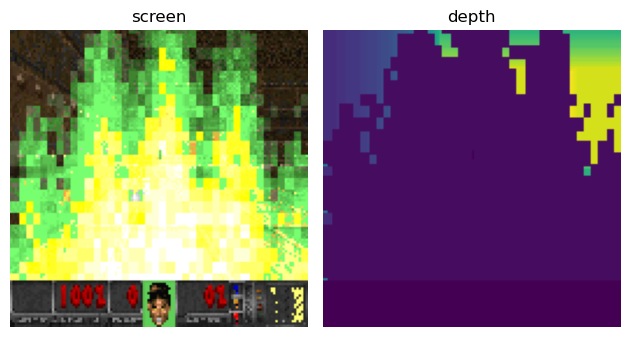

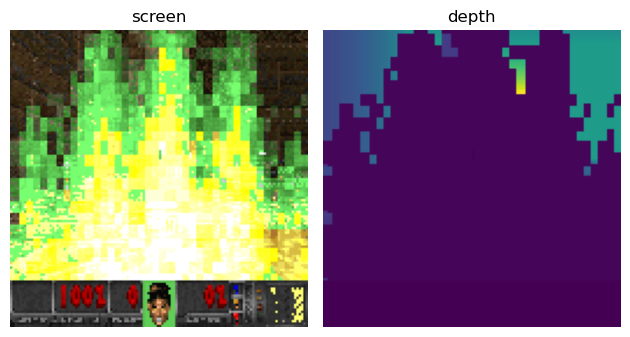

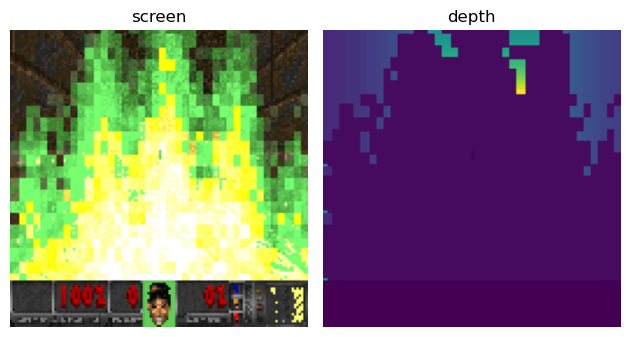

In [18]:
# Reset environment
with suppress_output():
    obs_test: list = env.reset()
    
for player in range(len(obs_test)):
    plot_images(obs_test[player], obs_states.get_dims())

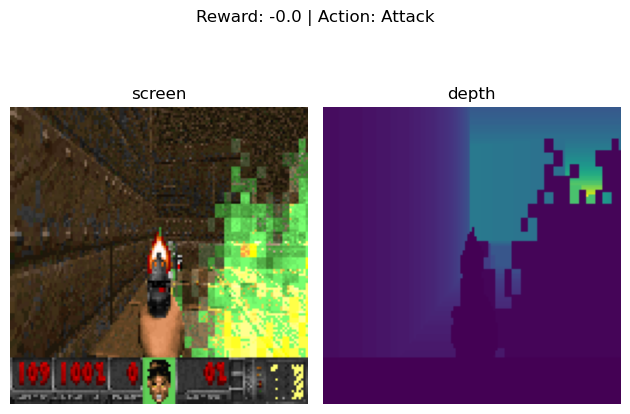

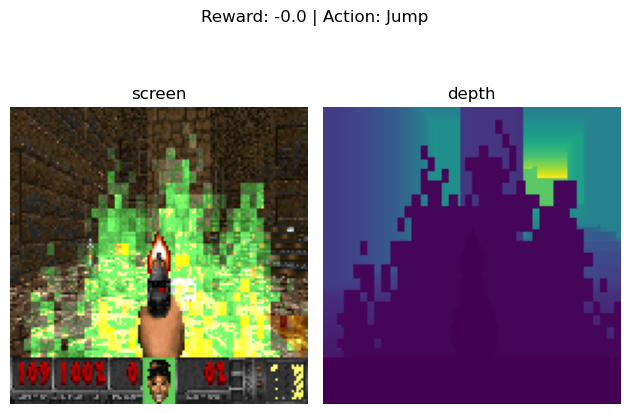

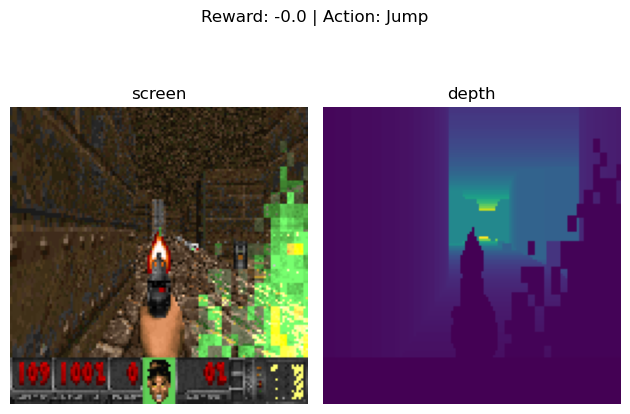

In [19]:
# Iterate 60 steps
STEPS = 30

with torch.no_grad():
    for i in range(STEPS):
        actions = env_actions.get_random_action(NUM_PLAYERS)
        #actions = env_actions.get_action_value(1, NUM_PLAYERS)
        #actions = epsilon_greedy(env, model, obs_test, 0.5, env_actions, device, DTYPE, debug=True) # 50% random actions by model
        actions = epsilon_greedy(env, model, torch.rand_like(torch.stack(obs_test)), 0, env_actions, device, DTYPE, debug=False) # model fully random
        obs_test, reward = env.step(actions)[0:2]

    for player in range(env.num_players):
        action_print = [actions] if isinstance(actions, int) else actions
        plot_images(obs_test[player], obs_states.get_dims(), **{"title": f"Reward: {reward[player]:.1f} | Action: {env_actions.get_action_name(action_print[player])}"})


### Example of Reward

In [20]:
player_idx = rng.integers(env.num_players)

player_game_vars = env.envs[player_idx].unwrapped._game_vars
player_game_vars_pre = env.envs[player_idx].unwrapped._game_vars_pre
reward = reward_fn(0, player_game_vars, player_game_vars_pre, 0)
print(f"Reward: {np.sum(reward)} | {reward}")
for key, value_now, value_old in zip(player_game_vars, player_game_vars.values(), player_game_vars_pre.values()):   
    print(f"{key+':':<25}{value_now:.0f} | {value_old:.0f}")

Reward: -0.005 | (0.0, 0.0, -0.0, 0, 0.0, -0.005, 0.0)
HEALTH:                  100 | 100
AMMO3:                   0 | 0
FRAGCOUNT:               0 | 0
ARMOR:                   0 | 0
HITCOUNT:                0 | 0
HITS_TAKEN:              0 | 0
DEAD:                    0 | 0
DEATHCOUNT:              0 | 0
DAMAGECOUNT:             0 | 0
DAMAGE_TAKEN:            0 | 0
KILLCOUNT:               0 | 0
SELECTED_WEAPON:         2 | 2
SELECTED_WEAPON_AMMO:    109 | 109
POSITION_X:              321 | 321
POSITION_Y:              416 | 416


## Training loop

In [21]:
def analyze_model_tensors(episode: int, obs_clean: tuple[torch.Tensor], model: nn.Module, model_sequence: list = [None, 0, 1, 1], print_once: bool = False):    
    rand_tensor = torch.rand(size=torch.stack(obs_clean).shape).to("cpu").split(obs_states.get_dims(return_dict=False), dim=1)
    
    value, advantage = activation_logger.log_model_activations(rand_tensor, model, model_sequence, episode=episode, return_activations_from_idx=-2, print_once=print_once)
    q_values = (value + advantage - advantage.mean(dim=1, keepdim=True)).to(dtype=DTYPE)
    q_actions = q_values.argmax(dim=1).to(dtype=DTYPE)
    
    log_qvals = activation_logger.analyze_activations(q_values, episode, title="Qvalues", print_once=print_once)
    log_qacts = activation_logger.analyze_activations(q_actions, episode, title="Actions", print_once=print_once)
    activation_logger.log(log_qvals + "\n" + log_qacts, improve_file_output=True)

N_STACK_FRAMES: 1, NUM_PLAYERS: 3, NUM_BOTS: 6, EPISODE_TIMEOUT: 200, GAMMA: 0.95, EPISODES: 2, BATCH_SIZE: 128, REPLAY_BUFFER_SIZE: 15000, LEARNING_RATE: 1e-05, EPSILON_START: 1.0, EPSILON_END: 0.1, EPSILON_DECAY: 0.998, N_EPOCHS: 20, FRAME_SKIPPING: 0, FRAME_SKIPPING_STOP: 100, DEBUG: True, PRINT_EVERY: 50, VIDEO_DURING_TRAINING: True, EVALUATION_EVERY: 50algo_type: QVALUE, n_stack_frames: 1, extra_state: ['depth'], hud: none, crosshair: True, screen_format: 0


Training:   0%|          | 0/2 [00:00<?, ? episode/s]

03:49:33 | Episode: 0 | Steps done: 0 | Gathering rollout (currently 0)
03:49:34 | Episode: 0 | Training for 20 epochs
03:49:40 | Episode: 0 | Updating target network...
03:49:40 | Episode: 0 | Rewards:
	Reward: [80.  1.  1.] | Avg Reward: 27.0 | Loss: 0.7285 | ε: 0.998 | LR: 9.99e-06
	Metrics - ['frags: 0', 'hits: 25', 'damage_taken: 0', 'movement: 0', 'ammo_efficiency: 3', 'survival: 0', 'health_pickup: 0']
	Actions - Noop: 25, Move Forward: 111, Attack: 157, Move Left: 57, Move Right: 52, Turn Left: 91, Turn Right: 80, Jump: 27
03:49:40 | Episode: 0 | Replaying animation...
03:49:46 | Episode: 0 | Running quick evaluation...
03:49:49 | Episode: 1 | Steps done: 200 | Gathering rollout (currently 597)
03:49:51 | Episode: 1 | Training for 20 epochs
03:49:52 | Episode: 1 | Updating target network...
03:49:52 | Episode: 1 | Rewards:
	Reward: [131.   1.   1.] | Avg Reward: 36.0 | Loss: 0.2719 | ε: 0.996 | LR: 9.96e-06
	Metrics - ['frags: 0', 'hits: 41', 'damage_taken: 0', 'movement: 0', '

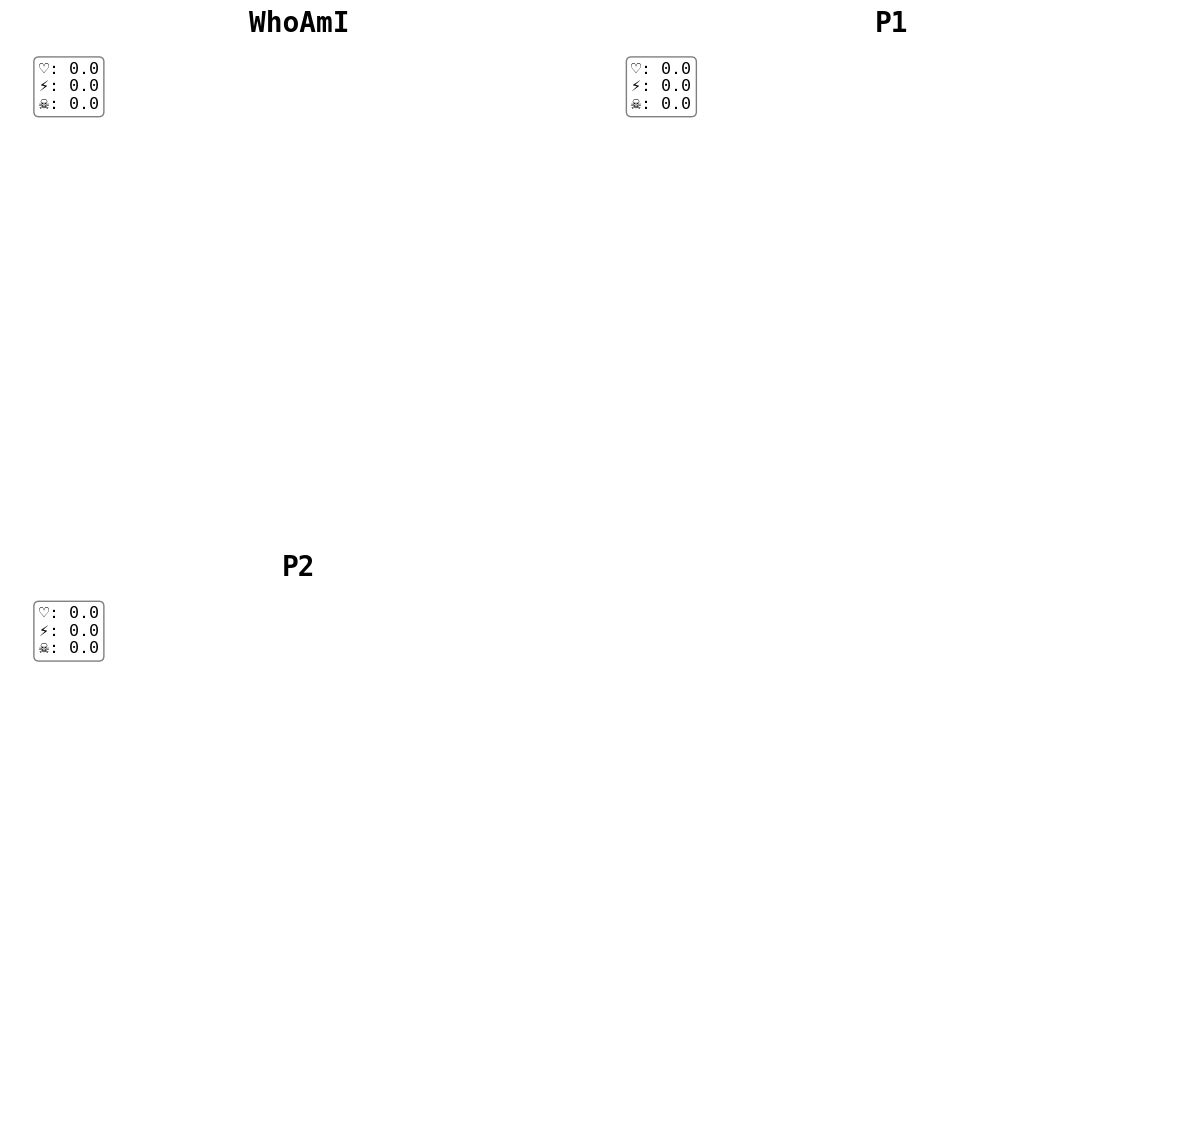

In [22]:
# ---------------------  TRAINING LOOP  ----------------------
training_info_str = (
    f"N_STACK_FRAMES: {N_STACK_FRAMES}, "
    f"NUM_PLAYERS: {NUM_PLAYERS}, "
    f"NUM_BOTS: {NUM_BOTS}, "
    f"EPISODE_TIMEOUT: {EPISODE_TIMEOUT}, "
    f"GAMMA: {GAMMA}, "
    f"EPISODES: {EPISODES}, "
    f"BATCH_SIZE: {BATCH_SIZE}, "
    f"REPLAY_BUFFER_SIZE: {REPLAY_BUFFER_SIZE}, "
    f"LEARNING_RATE: {LEARNING_RATE}, "
    f"EPSILON_START: {EPSILON_START}, "
    f"EPSILON_END: {EPSILON_END}, "
    f"EPSILON_DECAY: {EPSILON_DECAY}, "
    f"N_EPOCHS: {N_EPOCHS}, "
    f"FRAME_SKIPPING: {FRAME_SKIPPING}, "
    f"FRAME_SKIPPING_STOP: {FRAME_SKIPPING_STOP}, "
    f"DEBUG: {DEBUG}, "
    f"PRINT_EVERY: {PRINT_EVERY}, "
    f"VIDEO_DURING_TRAINING: {VIDEO_DURING_TRAINING}, "
    f"EVALUATION_EVERY: {EVALUATION_EVERY}"
)

training_info_str += ', '.join([f"{k}: {v}" for k, v in PLAYER_CONFIG.items()])

logger.log(training_info_str, improve_file_output=True)

# Training settings
q_loss_list, epsilon_history = [], []
reward_history = {player: [] for player in range(env.num_players)}
best_reward = float("-inf")
best_model = None

epsilon = EPSILON_START 
steps_done = 0


with TqdmProgress(total=EPISODES) as progress_bar:
    for episode in progress_bar:
        
        episode_action_counter = ActionCounter()
        progress_bar.set_description(episode)
        
        with suppress_output():
            #obs = torch.stack([env.reset() for env in environments.values()])
            obs: torch.Tensor = env.reset()
        
        # Episode variables for each player
        episode_metrics = {player: {"frags": 0, "hits": 0, "damage_taken": 0, "movement": 0, "ammo_efficiency": 0, "survival": 0, "health_pickup": 0} for player in range(env.num_players)}
        episode_reward = {player: 0.0 for player in range(env.num_players)}

        dones = [False]
        model.eval()
        
        episode_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Steps done: {steps_done} | Gathering rollout (currently {len(replay_buffer)})"
        logger.log(episode_msg)
        
        # ───────── rollout ─────────────────────────────────────────────
        while not all(dones):
            
            # Skip Frames (Testing - I am aware that in the original paper they stacked the images. I want to get many more steps at the beginning)
            act = epsilon_greedy(env, model, obs, epsilon, env_actions, device, DTYPE, episode_action_counter)
            
            max_skip_steps = max(FRAME_SKIPPING * (episode < FRAME_SKIPPING_STOP), 1)
            for skip_steps in range(max_skip_steps):
                if all(dones):
                    break
                next_obs, reward, dones, _ = env.step(act)
                steps_done += 1

            # ----- reward definition ----------------
            for player_idx in range(env.num_players):
                episode_reward[player_idx] += np.sum(reward[player_idx]) # Should be a list with one value
                
                if dones[player_idx]:
                    break
                
                reward_components = reward_fn(None, env.envs[player_idx].unwrapped._game_vars, env.envs[player_idx].unwrapped._game_vars_pre, None)

                if len(reward_components) >= 6:
                    episode_metrics[player_idx]["frags"] += reward_components[0]
                    episode_metrics[player_idx]["hits"] += reward_components[1]
                    episode_metrics[player_idx]["damage_taken"] += reward_components[2]
                    episode_metrics[player_idx]["movement"] += reward_components[3]
                    episode_metrics[player_idx]["ammo_efficiency"] += reward_components[4]
                    episode_metrics[player_idx]["survival"] += reward_components[5]
                    episode_metrics[player_idx]["health_pickup"] += reward_components[6]
            
                # ----- buffer and environment handling ----------------
                if env.num_players == 1:
                    act = [act]
                    
                replay_buffer.append((obs[player_idx], act[player_idx], reward[player_idx], next_obs[player_idx], dones[player_idx]))

            obs = next_obs
            
        [reward_history[player_idx].append(reward) for player_idx, reward in episode_reward.items()] # Append rewards for every player
        epsilon_history.append(epsilon)

        # ───────── learning step (experience replay) ──────────────────
        if len(replay_buffer) >= BATCH_SIZE:

            model.train()
            train_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Training for {N_EPOCHS} epochs"
            logger.log(train_msg)
            
            for epoch in range(N_EPOCHS):

                batch = random.sample(replay_buffer, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert to tensors for training
                states = torch.stack(states).to(device, DTYPE)
                next_states = torch.stack(next_states).to(device, DTYPE)
                actions = torch.tensor(actions, device=device)
                rewards = torch.tensor(rewards, device=device, dtype=torch.float32) #.squeeze(1) # Added squeeze here
                dones = torch.tensor(dones, device=device, dtype=torch.float32)

                current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Target q values
                with torch.no_grad():
                    next_q = target_model(next_states).max(1)[0] #.values
                    target_q = torch.clamp(rewards + GAMMA * next_q * (1 - dones), min=-10, max=10) # clamping to staibilize training
                
                loss = loss_fn(current_q, target_q) # TODO: Check whether correct, did that in Deep Q Assignment

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                q_loss_list.append(loss.item())
            
            # Update scheduler and epsilon
            scheduler.step()
            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
            
            progress_bar.update_step_count()

            # Update target network        
            target_update_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Updating target network..."
            logger.log(target_update_msg)
            
            soft_update_target_network(model, target_model, tau=1e-3)
            #hard_update_target_network(target_model, model)
            
        else:
            train_fail_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replay buffer smaller than batchsize {len(replay_buffer)} {BATCH_SIZE}"
            logger.log(train_fail_msg, print_once=True)

        # -------- logging ----------
        avg_reward = get_avg_reward(reward_history, episodes=PRINT_EVERY, round=0)
        avg_loss = np.mean(q_loss_list[-10:]) if q_loss_list else 0
        stacked_episode_reward = np.array([np.round(reward, 0) for reward in episode_reward.values()])
        
        action_counts = episode_action_counter.get_counts()

        # Rewards and losses
        reward_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Rewards:\n"
        reward_msg += f"\tReward: {stacked_episode_reward} | Avg Reward: {avg_reward} | Loss: {avg_loss:.4f} | ε: {epsilon:.3f} | LR: {scheduler.get_last_lr()[0]:.2e}"
        reward_msg += f"\n\tMetrics - {[f'{metric}: {value}' for metric, value in get_average_result(episode_metrics).items()]}"
        reward_msg += f"\n\tActions - {', '.join([f"{k}: {v}" for k, v in episode_action_counter.get_name_counts(env_actions).items()])}"

        logger.log(reward_msg, print_once = episode % PRINT_EVERY == 0)
        
        progress_bar.set_postfix({
            "Avg Reward": f"{avg_reward}",
            "Loss": f"{avg_loss:.4f}",
            "Epsilon": f"{epsilon:.2f}"
        })
            
        # Show the video 
        if VIDEO_DURING_TRAINING and episode % EVALUATION_EVERY == 0:
            replay_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replaying animation..."
            logger.log(replay_msg)
            with suppress_output():
                replay_episode(env, model, device, DTYPE, path=training_folder, store=True, random_player=False)
        
        # ───────── quick evaluation for best-model tracking ───────────
        quick_eval_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Running quick evaluation..."
        logger.log(quick_eval_msg)
        
        with suppress_output():
            eval_obs = env.reset() # List of obs
        
        # Return the tensors for analysis
        analyze_model_tensors(episode, eval_obs, model)

        # Evaluate every EVALUTATION EVERY periods to improve the speed
        if episode > 0 and episode % EVALUATION_EVERY == 0:
                        
            eval_episode_rewards = [0.0] * env.num_players
            eval_dones = [False]
            model.eval()
        
            while not all(eval_dones):
                eval_action_list = epsilon_greedy(env, model, eval_obs, 0, env_actions, device, dtype=DTYPE)
                eval_next_obs_list, eval_reward_list, eval_dones, _ = env.step(eval_action_list)
                for i in range(env.num_players):
                    eval_episode_rewards[i] += eval_reward_list[i]
                eval_obs = eval_next_obs_list
            
            mean_eval_reward = np.mean(eval_episode_rewards)
            
            if mean_eval_reward > best_reward:
                best_reward = mean_eval_reward
                model_name = f"best_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}_best{best_reward:.0f}_max{np.max(eval_episode_rewards):.0f}.pt"
                model.save_model(path=training_folder, filename=model_name)
                best_model = deepcopy(model)

## Dump to ONNX

In [23]:
import onnx
import json

def onnx_dump(env, model, config, filename: str):
    # dummy state
    with suppress_output():
        init_state = env.reset()[0].unsqueeze(0)

    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

    
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model  # choose best

onnx_filename = os.path.join(training_folder, "enhanced_doom_agent.onnx")
onnx_dump(env, final_model, PLAYER_CONFIG, onnx_filename)
print(f"Best network exported to {onnx_filename}")

Best network exported to runs/20250622_034926/enhanced_doom_agent.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


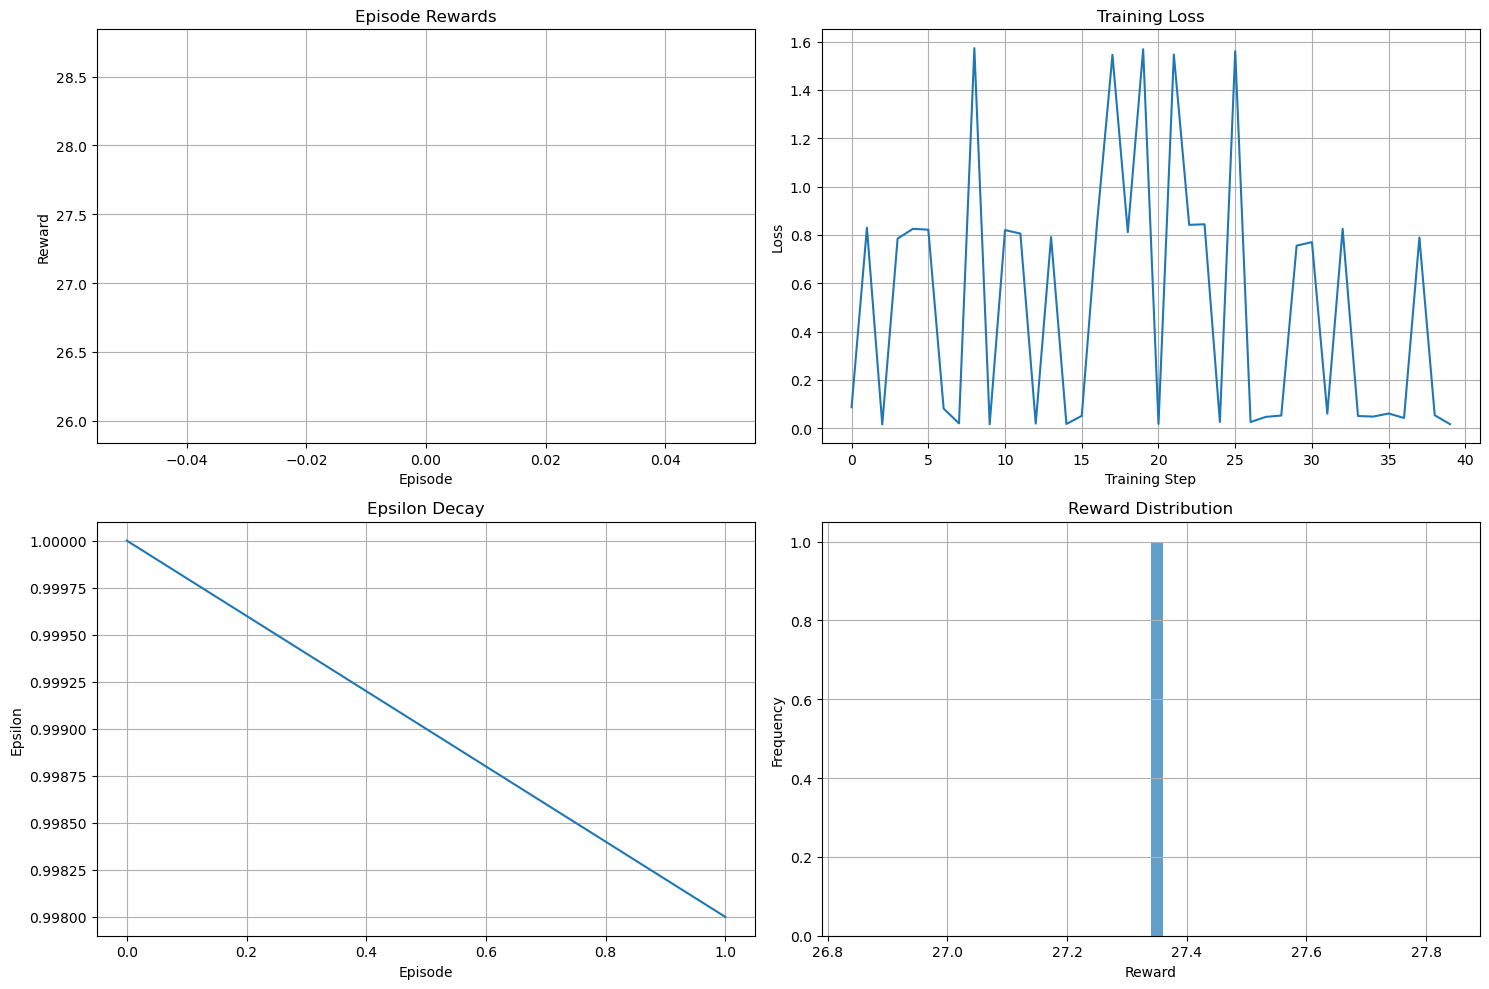

In [24]:
plot_training_metrics(get_avg_reward(reward_history, episodes=0), q_loss_list, epsilon_history)

Enabling replays!
Final evaluation - Total reward: 28.0
Disabling replays!
Animation saved to 2025-06-22_03-49-58_28.mp4


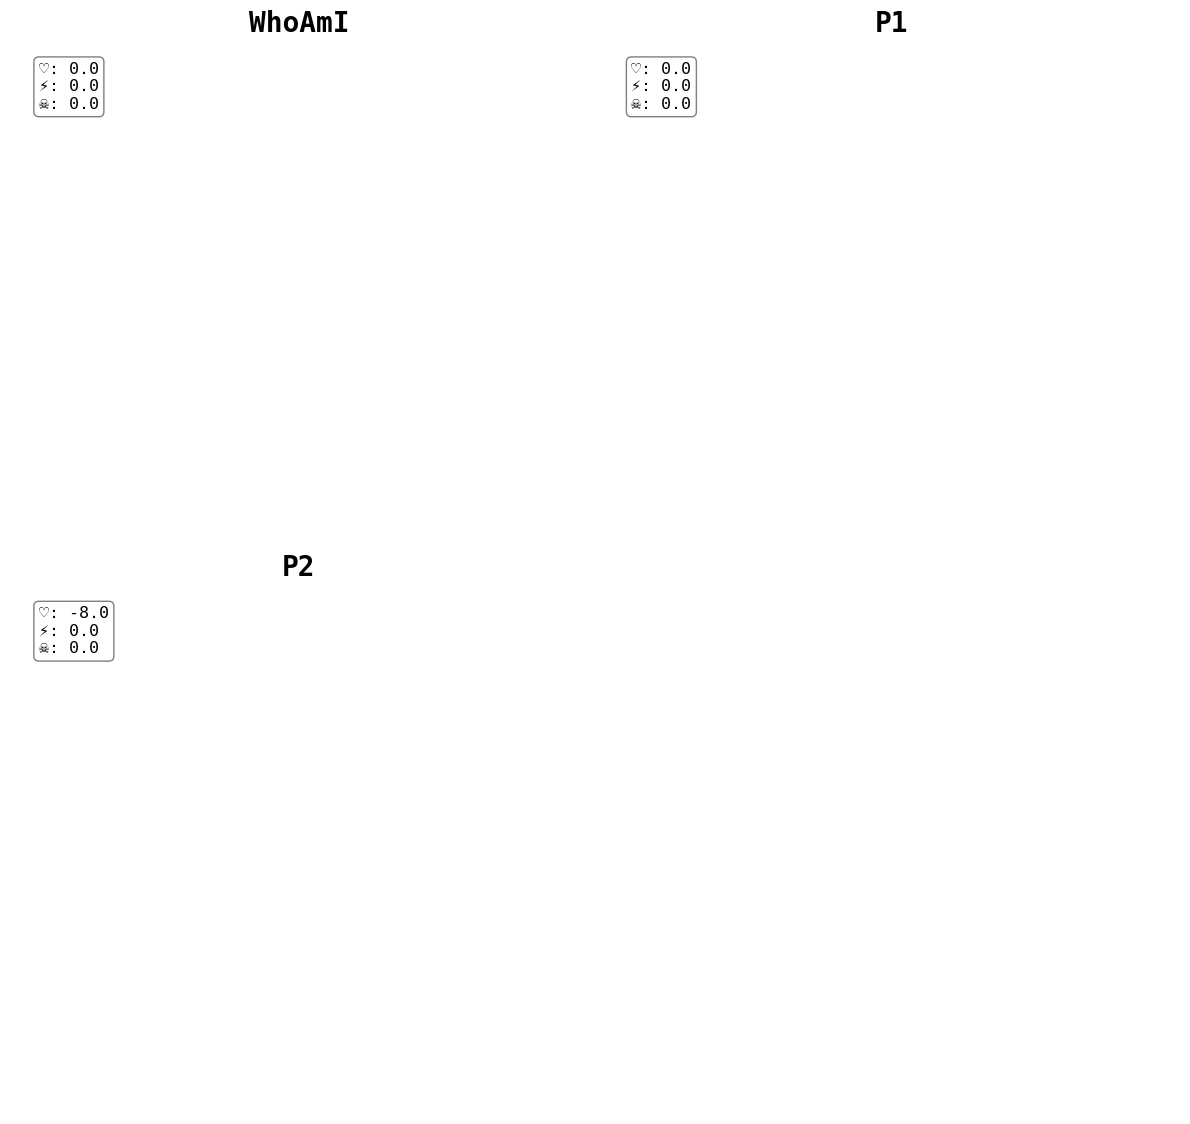

In [25]:
replay_episode(env, final_model.cpu(), device, DTYPE, store=True, random_player=False)